In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = (session.query(measurement.date).order_by(measurement.date.desc()).first())


2016-08-23


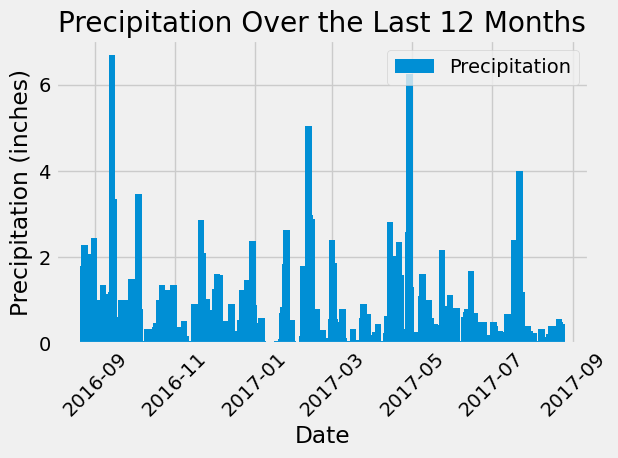

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017,8,23) - (dt.timedelta(days = 365))
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

#results = session.execute(query, {"format": "%Y-%m-%d", "one_year_ago": str(one_year_ago)}).fetchall()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
plt.bar(df['Date'], df['Precipitation'], width=5, label='Precipitation')
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Date,Precipitation
count,2230,2021.000000
mean,2017-02-16 05:31:15.874439424,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-18 00:00:00,0.000000
50%,2017-02-14 12:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
Station = Base.classes.station

total_stations = session.query(func.count(Station.station)).scalar()

print(f'The total number of stations in the dataset is: {total_stations}')

The total number of stations in the dataset is: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station).label('count')).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

# Display the results
for station, count in active_stations:
    print(f'Station ID: {station}, Count: {count}')

Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()
if most_active_station:
    most_active_station_id = most_active_station[0]

    temperature_stats = session.query(func.min(measurement.tobs).label('min_temp'),
                                     func.max(measurement.tobs).label('max_temp'),
                                     func.avg(measurement.tobs).label('avg_temp')).\
        filter(measurement.station == most_active_station_id).all()

    for result in temperature_stats:
        print(f"Most Active Station ID: {most_active_station_id}")
        print(f"Lowest Temperature: {result.min_temp}")
        print(f"Highest Temperature: {result.max_temp}")
        print(f"Average Temperature: {result.avg_temp}")
        
else:
    print("No active station.")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


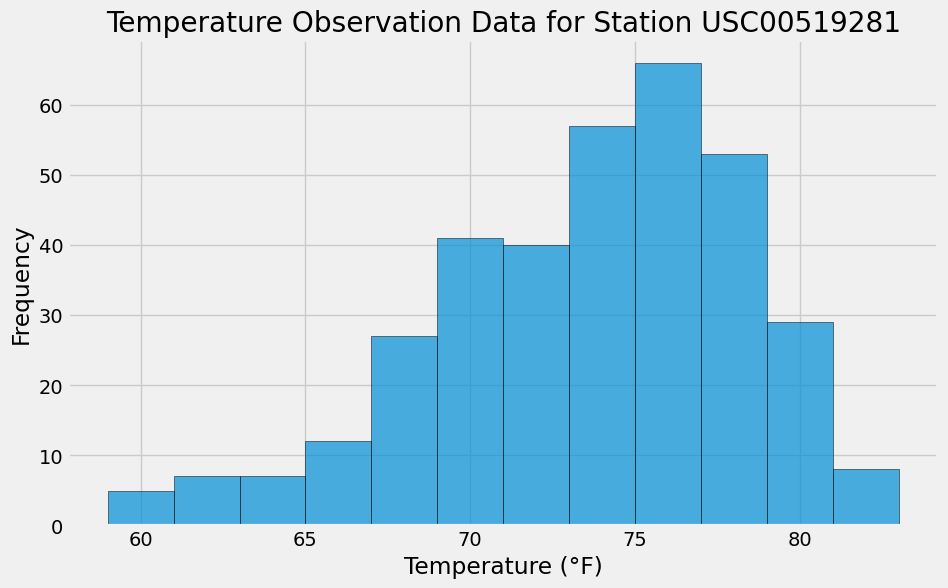

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(measurement.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()

if most_active_station:
    most_active_station_id = most_active_station[0]
    
latest_date = session.query(func.max(measurement.date)).scalar()
one_year_ago = dt.date(2017,8,23) - (dt.timedelta(days = 365))

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

 # Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(column_df['Temperature'], bins=12, edgecolor='black', alpha=0.7)
plt.title(f'Temperature Observation Data for Station {most_active_station_id}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [17]:
# Close Session
session.close()